
Sections: 
1. Imports
2. Creating / reading the file
3. Data collection
4. Tokenization
5. Data cleaning
6. Exploratory analysis

Creating and Cleaning a Data Set: https://www.analyticsvidhya.com/blog/2022/02/exploratory-data-analysis-in-python/


Explanation: https://www.analyticsvidhya.com/blog/2021/06/data-cleaning-using-pandas/



#Get tweets

This file retrieves new tweets and adds it to the existing full_list.csv file. 



---



Packages and imports

In [ ]:
!pip install -q lib5c
!lib5c -v

     |████████████████████████████████| 16.2 MB 648 kB/s 
     |████████████████████████████████| 1.2 MB 18.5 MB/s 
lib5c version 0.6.1


In [ ]:
pip install searchtweets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install nrclex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 13.9 MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=4f29825b634413c583284f090afd660ab92388f7ab43aac53cdb2653706f6b1e
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built nrclex


In [ ]:
from ctypes import sizeof
import re
import pandas as pd
import tweepy
import math
import csv
import ast
import searchtweets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from getpass import getuser
from operator import delitem
from tweepy import OAuthHandler
from textblob import TextBlob
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [ ]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Class object --> Separates each tweet into:
                    - Screen name, # of likes, # of retweets, date of the tweet, if the user is verified, whether or not the user has geolocation on, URL of the tweet and the tweet itself

In [ ]:
class TwitterClient(object):

    # Keys for access
    def __init__(self):

        consumer_key = 'szkg6CocRy4QY8fQ9psiWMPV9'
        consumer_secret = '8NgATpZV3a1BQVyi2biaFgLI7V6G0gP9qMonyv6WjONJNsXWCo'
        access_token = '1496547674107092992-AuI9z475YIeHCtxvgD3dXVqJ9Tluw0'
        access_token_secret = '7GKOQuQ4ixPMl1yWPl7Jew4ASR5l92x2flmOFtxevws8r'

        # Authentication of the keys
        try:
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            self.auth.set_access_token(access_token, access_token_secret)
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")

    # Cleans tweets from unneccessary links and special characters
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


    # Function to get tweetes and separate into their own categories
    def get_tweets(self, query, count = 500):

        tweets = [] 
        

        try:
            
            fetched_tweets = self.api.search(q = query, count = count)

            
            for tweet in fetched_tweets:
                parsed_tweet = {}
                tweet_id = tweet.id
                status = self.api.get_status(tweet_id,tweet_mode="extended")

                parsed_tweet['screen name'] = tweet.user.screen_name
                parsed_tweet['likes'] = tweet.favorite_count
                parsed_tweet['retweets'] = tweet.retweet_count
                parsed_tweet['date'] = tweet.created_at
                parsed_tweet['verified'] = tweet.user.verified
                parsed_tweet['geo'] = tweet.geo
                parsed_tweet['URL'] = "https://twitter.com/"+tweet.user.screen_name+"/status/"+str(tweet_id)
                parsed_tweet['text'] = self.clean_tweet(status.full_text)
                
                if tweet.retweet_count > 0:
                    
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)

            
            return tweets

        except tweepy.TwitterServerError as e:
            # print error (if any)
            print("Error : " + str(e))

# Function to turn all the twitter data into a csv file 
def csv_file(dataframe):
    csv.register_dialect('twitter',delimiter='\n', quoting=csv.QUOTE_NONE)
    twitter_file = open('tweets.csv','w')
    tweets_df = pd.DataFrame.from_dict(dataframe)
    sort_tweets = tweets_df.sort_values(by=['likes'], ascending=False)
    with twitter_file:
        sort_tweets.to_csv(twitter_file)
    twitter_file.close()

        
# The function to call to get all the tweets 
def run_tweets():
    api = TwitterClient()
    query = "PFOS OR PFAS OR Per-and-polyfluoroalkyl OR PFOA OR PFHxA OR PFBA OR forever-chemicals OR fluorinated-compounds AND lang:en AND -filter:retweets"
    tweets = api.get_tweets(query = query, count = 500)
    return tweets

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/full_list.csv'

Mounted at /content/drive


In [ ]:
all_of_tweets = run_tweets()

In [ ]:
column_names = [' ', 'screen name', 'likes','retweets','date','verified','geo','URL','text']

#new_df: The most recent instance of running the program. The data in this data frame will be added to the existing file. 
df = pd.DataFrame(data = all_of_tweets, columns=column_names)
df.to_csv(path_or_buf= '/content/drive/My Drive/full_list.csv', mode='a', index=False, header=False)



---



#Sentiment code: 

Tokenization means that we are separating each word in the tweet into single words to be used

In [ ]:
df['text'] = df['text'].astype(str)

In [ ]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
df.text = [tknzr.tokenize(tweets) for tweets in df.text]

In [ ]:
le = WordNetLemmatizer()
lemma_text = []
for index in range(len(df.text)):
    tweet = [le.lemmatize(word,pos = "n") for word in df.text[index]]
    lemma_text.append(tweet)

print(lemma_text[0:10])


[['Chairman', 'HQ', 'Great', 'news', 'Brian'], ['Dangerous', 'forever', 'chemical', 'found', 'in', 'Florida', 'oyster', 'study'], ['Wisconsin', 'PFAS', 'Lawsuit', 'Moves', 'from', 'State', 'to', 'Federal', 'Court'], ['What', 'business', 'should', 'know', 'about', 'Colorado', 's', 'new', 'forever', 'chemical', 'ban', 'more'], ['need', 'to', 'direct', 'water', 'provider', 'to', 'notify', 'their', 'customer', 'about', 'PFOA', 'and', 'PFOS', 'in', 'the', 'water', 'a', 'recommends'], ['Demand', 'Justice', 'For', 'The', 'Military', 's', 'Legacy', 'Of', 'Poison'], ['Demand', 'Justice', 'For', 'The', 'Military', 's', 'Legacy', 'Of', 'Poison'], ['Among', 'the', 'scariest', 'PFAS', 'fact', 'is', 'that', 'forever', 'chemical', 'go', 'into', 'sludge', 'that', 'grows', 'our', 'food', 'and', 'I', 'couldn', 't', 'get', 'info', 'for', 'Bmore', 'because', 'they', 'outsource', 'to', 'a', 'private', 'co', 'but', 'ha', 'them', 'for', 'Illinois', 'Great', 'reporting'], ['Last', 'week', 'Senate', 'Republica

In [ ]:
stop = set(stopwords.words('english'))
all_stop =['https', 'say','a','A','b','B']
tokens_without_sw =[]
for index in range (len(lemma_text)):
  tokens = [word for word in lemma_text[index] if not word in stop]
  tokens_without_sw.append(tokens)

In [ ]:
tokens_without_all_stop =[]
for index in range (len(tokens_without_sw)):
  tokens = [word for word in tokens_without_sw[index] if not word in all_stop]
  tokens_without_all_stop.append(tokens)

In [ ]:
tokens_without_all_stop[:1]

[['Chairman', 'HQ', 'Great', 'news', 'Brian']]

In [ ]:
tokens_filtered =[]
for index in range (len(tokens_without_all_stop)):
  tokens = [token  for token in tokens_without_all_stop[index] if len(token)>3]
  tokens_filtered.append(tokens)
tokens_filtered[0]

['Chairman', 'Great', 'news', 'Brian']

In [ ]:
for i in range(len(tokens_filtered)):
    tokens_filtered[i] = ' '.join(tokens_filtered[i])
df['text'] = tokens_filtered

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
df['sentiment'] = df['text'].apply(lambda tweet:sia.polarity_scores(tweet))
df['sentiment'][0:10]
df['compound'] = df['sentiment'].apply(lambda x:x['compound'])
df['compound_result'] = df['compound'].apply(lambda score: 'pos' if score > 0 else ('neg' if score < 0 else 'neu'))
df = df[['screen name', 'sentiment', 'compound', 'compound_result', 'likes','retweets','date','verified','geo','URL','text']]
df

,screen name,sentiment,compound,compound_result,likes,retweets,date,verified,geo,URL,text
0,pfoa_uk,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.6249,pos,0,0,2022-08-01 15:51:25,False,None,https://twitter.com/pfoa_uk/status/15541327051...,Chairman Great news Brian
1,carter_embrey,"{'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'comp...",-0.4767,neg,0,0,2022-08-01 15:50:50,False,None,https://twitter.com/carter_embrey/status/15541...,Dangerous forever chemical found Florida oyste...
2,Oldlady12345,"{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp...",-0.2263,neg,0,0,2022-08-01 15:45:06,False,None,https://twitter.com/Oldlady12345/status/155413...,Wisconsin PFAS Lawsuit Moves State Federal Court
3,BestJobSearch1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,0,0,2022-08-01 15:44:48,False,None,https://twitter.com/BestJobSearch1/status/1554...,What business know Colorado forever chemical
4,tvick_IYKYK,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp...",0.2263,pos,0,0,2022-08-01 15:43:20,False,None,https://twitter.com/tvick_IYKYK/status/1554130...,need direct water provider notify customer PFO...
...,...,...,...,...,...,...,...,...,...,...,...
95,RobertBilott,"{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp...",-0.6597,neg,35,13,2022-08-01 12:58:13,False,None,https://twitter.com/RobertBilott/status/155408...,Beyond shameful took decade finally take step ...
96,McclainPadgett,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp...",-0.5267,neg,1,1,2022-08-01 12:49:47,False,None,https://twitter.com/McclainPadgett/status/1554...,Vote VoteNo PACTAct Veteran BurnPit ToxicExpos...
97,McclainPadgett,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp...",-0.5267,neg,0,0,2022-08-01 12:49:05,False,None,https://twitter.com/McclainPadgett/status/1554...,Vote VoteNo PACTAct Veteran BurnPit ToxicExpos...
98,xethorn,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu,0,0,2022-08-01 12:44:43,False,None,https://twitter.com/xethorn/status/15540857197...,Most manufacturer water source Wondering long ...


In [ ]:
#Existing Data Frame
#df = pd.read_csv('/content/drive/My Drive/full_list.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


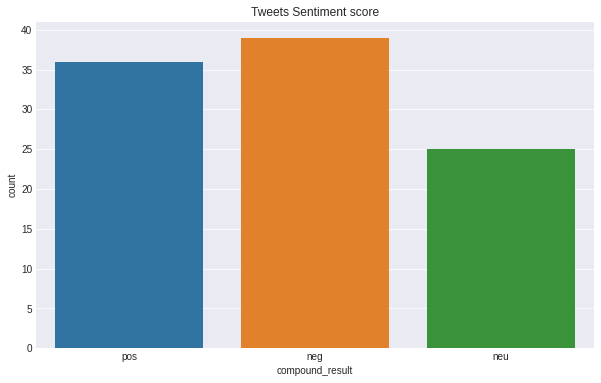

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df['compound_result'])
plt.title('Tweets Sentiment score');

In [ ]:
df['text'] = df['text'].str.strip()

In [ ]:
df['text'] = df['text'].str.strip()
text_unicode = str([cell.encode('utf-8') for cell in df['text']])

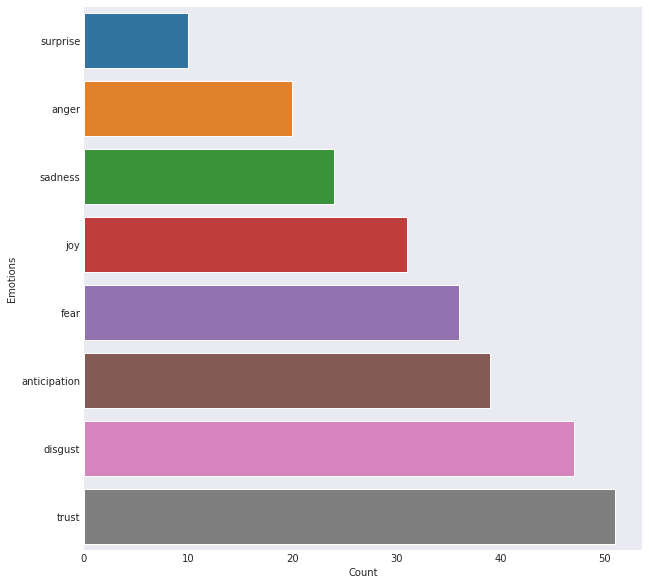

In [ ]:
emotion_score = NRCLex(text_unicode)
emotion_score = emotion_score.raw_emotion_scores
emotion_score = pd.DataFrame(emotion_score,index=[0])
emotion_score = pd.melt(emotion_score)

emotion_score.columns = ('Emotions','Count') 
emotion_score = emotion_score.sort_values('Count')

plt.figure(figsize=(10,10))
sns.set_style('dark')
sns.barplot(y='Emotions',x='Count',data = emotion_score[:8]);



---



In [ ]:
df.dtypes

screen name                object
sentiment                  object
compound                  float64
compound_result            object
likes                       int64
retweets                    int64
date               datetime64[ns]
verified                     bool
geo                        object
URL                        object
text                       object
dtype: object

In [ ]:
wc = WordCloud(height=1500, width=4000).generate(text_unicode)
wc.generate(" ".join(df['text']))

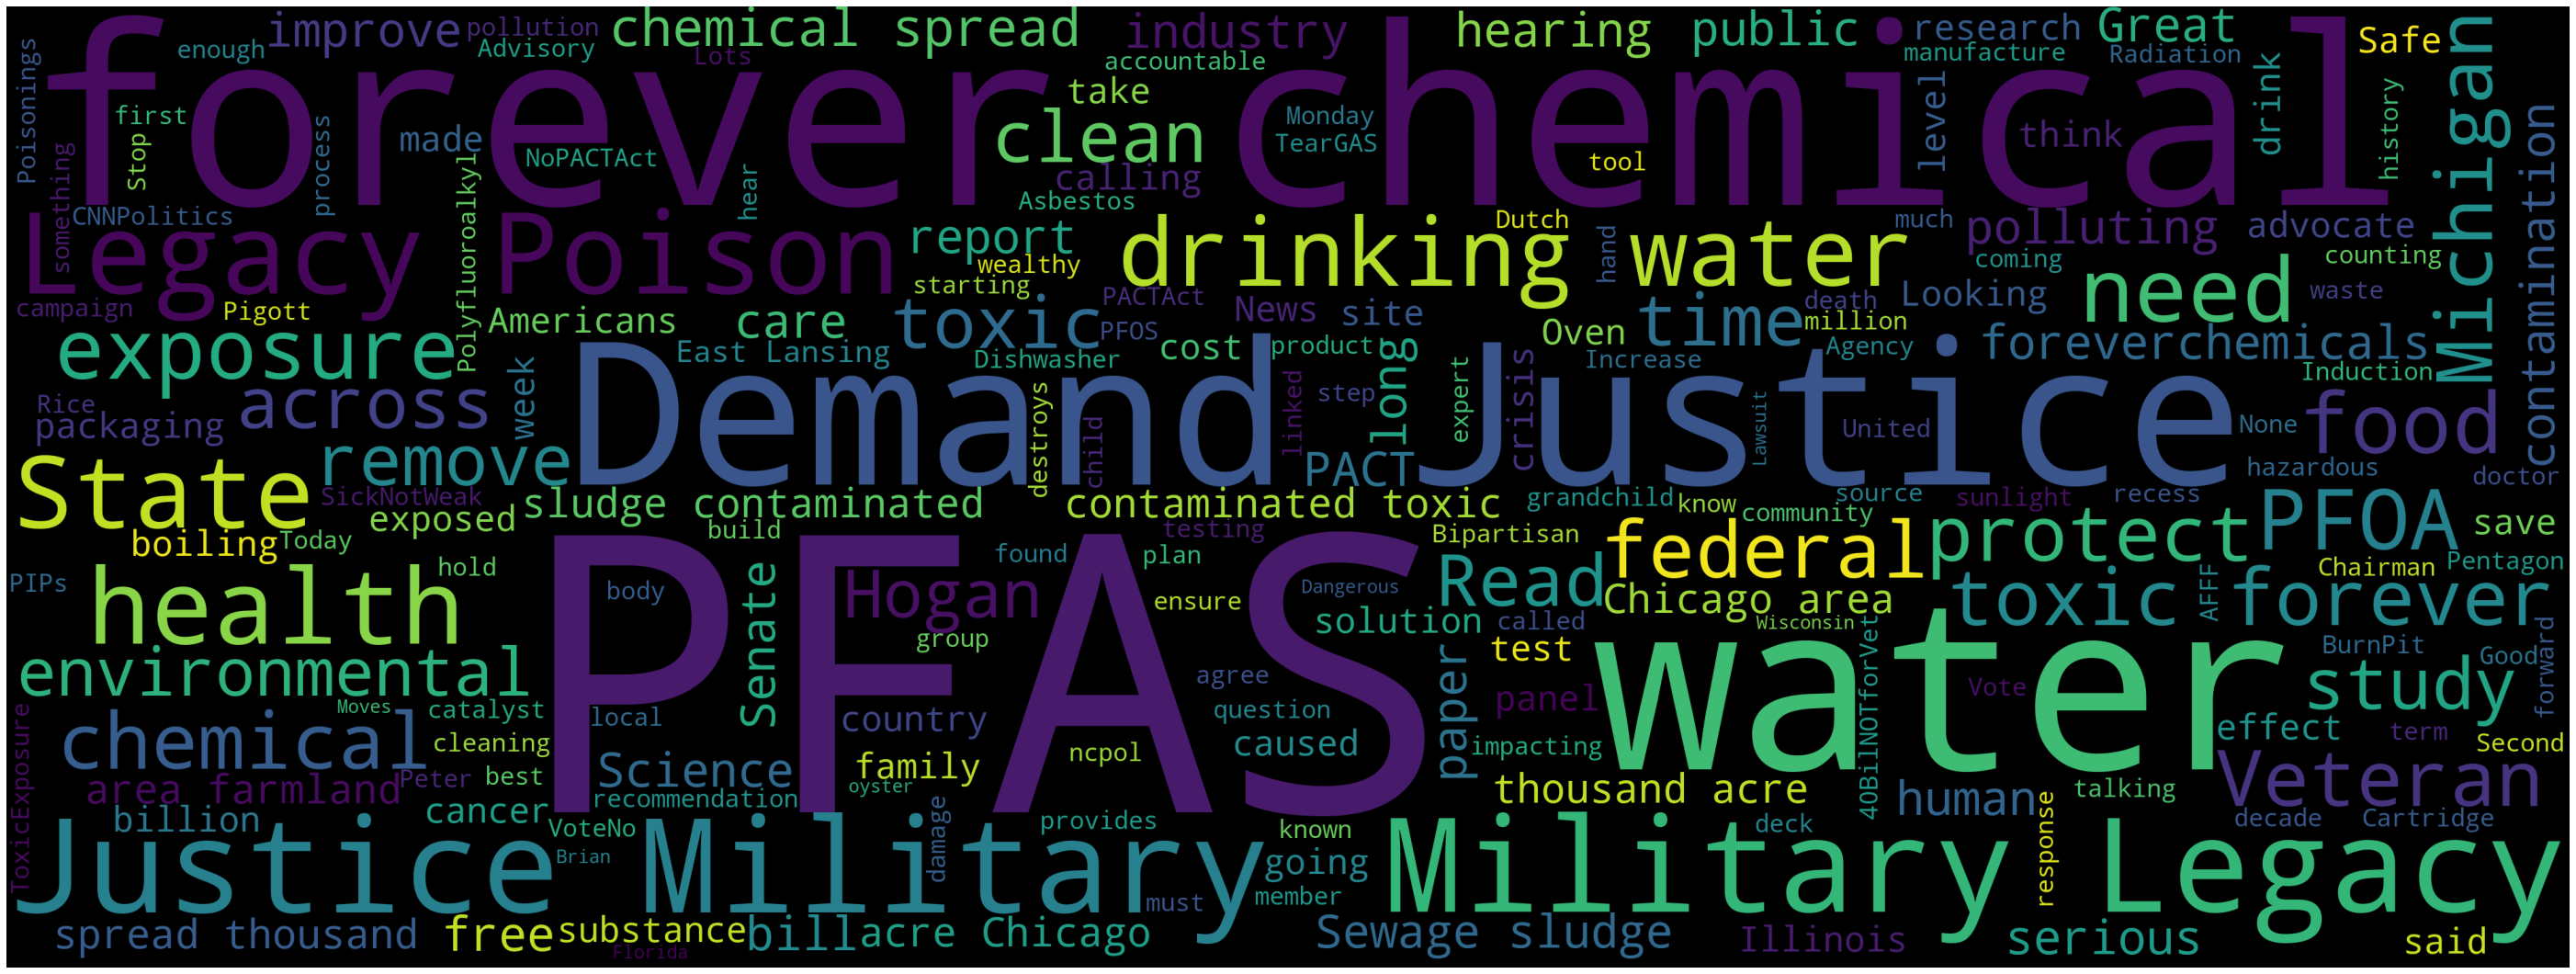

In [ ]:
plt.figure(figsize = (50,50))
plt.imshow(wc)
plt.axis('off')
plt.show()



---



In [ ]:
csv_file(df)

#Beginning of the Exploratory Analysis

---



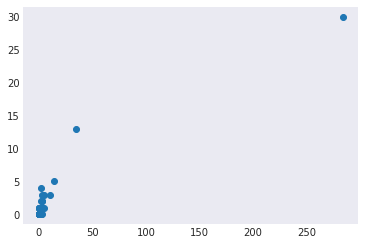

In [ ]:
plt.scatter(df['likes'], df['retweets'])

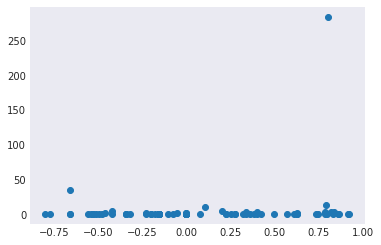

In [ ]:
plt.scatter(df['compound'], df['likes'])

(array([ 5.,  8.,  6., 17., 28.,  5., 10.,  3.,  6., 12.]),
 array([-0.802  , -0.62949, -0.45698, -0.28447, -0.11196,  0.06055,
         0.23306,  0.40557,  0.57808,  0.75059,  0.9231 ]),
 <a list of 10 Patch objects>)

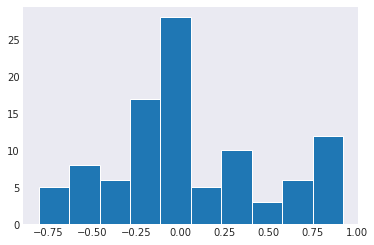

In [ ]:
plt.hist(df['compound'])

(array([36.,  0.,  0.,  0.,  0., 39.,  0.,  0.,  0., 25.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

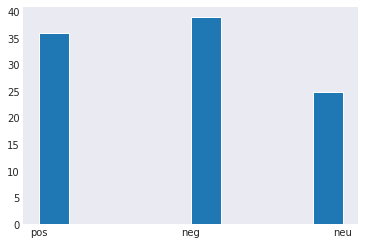

In [ ]:
plt.hist(df['compound_result'])